# Computer Vision and Language Models project

Group: The Karate Kid

- [Ettore Ricci](https://github.com/Etto48)
- [Paolo Palumbo](https://github.com/paolpal)
- [Zahra Omrani](https://github.com/zahra-omrani)
- [Erni Delialisi](https://github.com/erni-de)

The whole codebase can be found on [GitHub](https://github.com/Etto48/CVProject).

## Introduction

The goal of this project is to build a model that can generate a textual description of an image.
We used the [COCO dataset](https://cocodataset.org/#home).
Our model is a combination of a pre-trained ViT and a GPT-like model trained from scratch.
The overall architecture is inspired by GIT (Generative Image Transformer) from Microsoft.

The pre-trained ViT is [DINOv2](https://arxiv.org/abs/2304.07193).

GIT paper can be found [here](https://arxiv.org/abs/2205.14100).

In [ ]:
%pip install torch tiktoken transformers pandas torchvision numpy matplotlib scikit-learn

In [ ]:
from typing import Literal, Optional, Callable
import torch
import requests
from torch import nn
import tiktoken
from tqdm.auto import tqdm
import transformers
import json
import os
import zipfile
from torch.utils.data import Dataset
import pandas as pd
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import sklearn
import sklearn.decomposition

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ettore/Documents/Notes/AIDE 2/Multimedia information retrieval and computer vision/CVProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

The dataset is the COCO dataset, which contains images and (among other things) their textual descriptions.
We used the 2017 version of the dataset, which can be downloaded from the [official website](https://cocodataset.org/#download).

In [2]:
class TextImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        assert 'caption' in df.columns
        assert 'image_path' in df.columns
        self.df = df
        self.tokenizer = tiktoken.get_encoding("gpt2")
    
    @staticmethod
    def load(captions_path: str, images_path: str):
        img_name_padding = 12
        
        with open(captions_path, "r") as f:
            captions_data = json.load(f)["annotations"]
        df_list = []
        for caption_data in tqdm(captions_data, desc="Loading dataset"):
            image_id = caption_data["image_id"]
            caption = caption_data["caption"]
            image_name = f"{str(image_id).zfill(img_name_padding)}.jpg"
            image_path = os.path.join(images_path, image_name)
            df_list.append({"caption": caption, "image_path": image_path})
        df = pd.DataFrame.from_dict(df_list)
        return TextImageDataset(df)
    
    @staticmethod
    def load_train():
        return TextImageDataset.load(os.path.expanduser("~/Downloads/COCO/annotations_trainval2017/annotations/captions_train2017.json"), os.path.expanduser("~/Downloads/COCO/train2017"))
    
    @staticmethod
    def load_valid():
        return TextImageDataset.load(os.path.expanduser("~/Downloads/COCO/annotations_trainval2017/annotations/captions_val2017.json"), os.path.expanduser("~/Downloads/COCO/val2017"))
    
    @staticmethod
    def download(valid: bool = False):
        if valid:
            imgs = "http://images.cocodataset.org/zips/val2017.zip"
        else:
            imgs = "http://images.cocodataset.org/zips/train2017.zip"
        annotations = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
        coco_path = os.path.expanduser("~/Downloads/COCO")
        os.makedirs(coco_path, exist_ok=True)

        # Downloading imgs2017.zip
        imgs_path = f"{coco_path}/train2017.zip" if not valid else f"{coco_path}/val2017.zip"
        if not os.path.exists(imgs_path):
            val_imgs_stream = requests.get(imgs, stream=True)
            val_size = int(val_imgs_stream.headers.get("Content-Length", 0))
            with open(imgs_path, "wb") as f:
                with tqdm(
                    total=val_size, 
                    unit="B", 
                    unit_scale=True, 
                    desc="Downloading images") as bar:
                    for chunk in val_imgs_stream.iter_content(chunk_size=4096):
                        f.write(chunk)
                        bar.update(len(chunk))
        
        # Downloading annotations_trainval2017.zip
        if not os.path.exists(f"{coco_path}/annotations_trainval2017.zip"):
            annotations_stream = requests.get(annotations, stream=True)
            annotations_size = int(annotations_stream.headers.get("Content-Length", 0))
            with open(f"{coco_path}/annotations_trainval2017.zip", "wb") as f:
                with tqdm(
                    total=annotations_size, 
                    unit="B", 
                    unit_scale=True, 
                    desc="Downloading annotations") as bar:
                    for chunk in annotations_stream.iter_content(chunk_size=4096):
                        f.write(chunk)
                        bar.update(len(chunk))
        
        # Extracting val2017.zip
        imgs_path = imgs_path[:-4] # remove .zip
        if not os.path.exists(imgs_path):
            with zipfile.ZipFile(f"{imgs_path}.zip", "r") as zip_ref:
                zip_ref.extractall(coco_path)

        # Extracting annotations_trainval2017.zip
        os.makedirs(f"{coco_path}/annotations_trainval2017", exist_ok=True)
        if not os.path.exists(f"{coco_path}/annotations_trainval2017/annotations"):
            with zipfile.ZipFile(f"{coco_path}/annotations_trainval2017.zip", "r") as zip_ref:
                zip_ref.extractall(f"{coco_path}/annotations_trainval2017")

        if valid:
            return TextImageDataset.load_valid()
        else:
            return TextImageDataset.load_train()
    
    def __len__(self):  
        return len(self.df)

    def _load_image(self, image_path: str):
        image = torchvision.io.decode_image(torchvision.io.read_file(image_path))
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        return image
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        caption = row["caption"]
        plaintext_caption = caption
        image_path = row["image_path"]
        image = self._load_image(image_path)
        caption = [self.tokenizer.max_token_value] + self.tokenizer.encode(caption) + [self.tokenizer.max_token_value]
        caption = torch.tensor(caption, dtype=torch.long)
        return image, caption, plaintext_caption
    
    @staticmethod
    def collate_fn(batch: list):
        images, captions, plaintext_caption = zip(*batch)
        lengths = torch.tensor([len(c) for c in captions])
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
        return images, captions, lengths, plaintext_caption

In [3]:
# train = TextImageDataset.load_train()
valid = TextImageDataset.download(valid=True)

Loading dataset: 100%|██████████| 25014/25014 [00:00<00:00, 684653.62it/s]


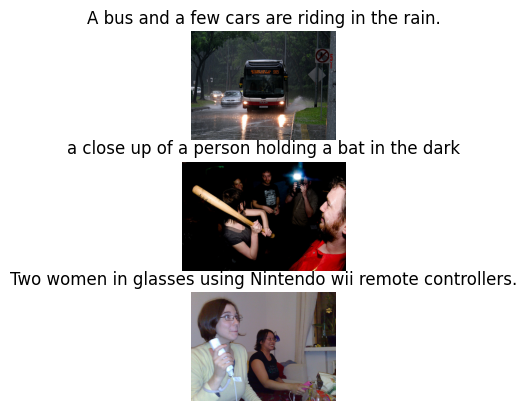

In [4]:
h = 3
w = 1
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, batch_size=h*w, collate_fn=TextImageDataset.collate_fn,
    sampler=torch.utils.data.RandomSampler(valid, replacement=True, num_samples=h * w))
images, _, _, captions = next(iter(valid_loader))
for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(captions[i])
    plt.axis("off")
plt.show()

## DINOv2

We used a pre-trained ViT model, DINOv2. It was trained with a self-supervised learning approach.
During the training, two models are trained: a teacher and a student.

The teacher model is used to generate the pseudo-labels for the student model.
The student model is trained to predict the pseudo-labels generated by the teacher model.

The resulting model is capable of extracting meaningful and robust features from the input images.

In [5]:
img_processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-large')
img_embedding = transformers.AutoModel.from_pretrained('facebook/dinov2-large').to(device)

Now we will display an example of the PCA of the features for some images. The features are relative to their respective patch of the image.

There are 3 plots for each image:
- The first shows the image.
- The second shows the PCA relative to all the images. Here we can see that similar objects in different images are colored similarly.
- The third shows the PCA relative to the image itself. Here we can see that the different components of an object are colored differently while similar objects are still colored similarly.

These plots show that DINOv2 is capable of extracting both global and local features from the images.


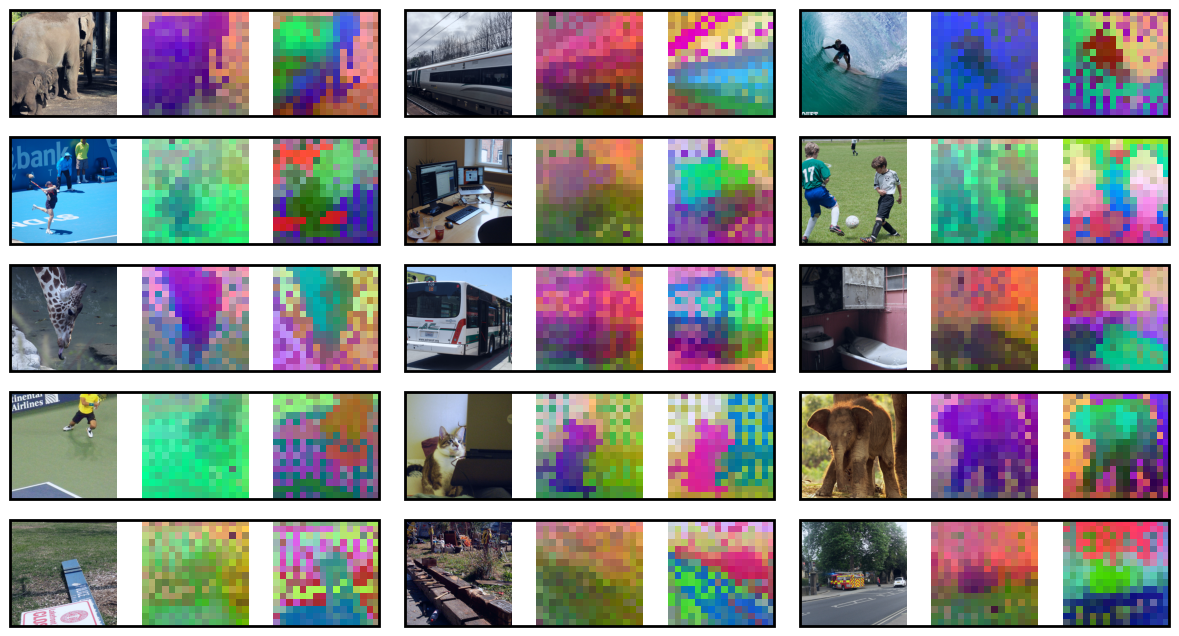

In [ ]:
def image_embedding_to_pca(image_embedding: torch.Tensor):
    if len(image_embedding.shape) == 2:
        image_embedding = image_embedding.unsqueeze(0)
    assert len(image_embedding.shape) == 3, f"Expected 3D tensor of batched embeddings, got {image_embedding.shape}"
    batch_size = image_embedding.shape[0]
    image_embedding = image_embedding[:, 1:, :]
    edge_square = image_embedding.shape[1]
    feature_size = image_embedding.shape[2]
    edge = int(edge_square ** 0.5)
    assert edge ** 2 == edge_square, f"Expected square image embeddings, got {edge_square}"
    pca_local = [sklearn.decomposition.PCA(n_components=3)] * batch_size
    pca = sklearn.decomposition.PCA(n_components=3)
    pca.fit(image_embedding.reshape(batch_size * edge_square, feature_size).cpu().numpy())
    ret_local = []
    ret = []
    image_embedding = image_embedding.cpu().numpy()
    for i in range(batch_size):
        pca_local[i].fit(image_embedding[i])
        pca_img = pca.transform(image_embedding[i]).reshape(edge, edge, 3)
        pca_img = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())
        ret.append(pca_img)
        pca_img_local = pca_local[i].transform(image_embedding[i]).reshape(edge, edge, 3)
        pca_img_local = (pca_img_local - pca_img_local.min()) / (pca_img_local.max() - pca_img_local.min())
        ret_local.append(pca_img_local)
    return ret, ret_local

h = 5
w = 3
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, batch_size=h * w, collate_fn=TextImageDataset.collate_fn,
    sampler=torch.utils.data.RandomSampler(valid, replacement=False, num_samples=h * w, generator=torch.Generator().manual_seed(4)))
images, _, _, _ = next(iter(valid_loader))
with torch.no_grad():
    preprocessed_images = img_processor(images, return_tensors="pt").to(device)
    image_embeddings = img_embedding(**preprocessed_images).last_hidden_state
pca, pca_local = image_embedding_to_pca(image_embeddings)
fig = plt.figure(figsize=(15, 8))
for i in range(h*w):
    plt.subplot(h, 3*w, 3*i + 1)
    img = preprocessed_images["pixel_values"][i].permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img.cpu())
    plt.axis("off")
    begin = plt.gca().get_position()
    plt.subplot(h, 3*w, 3*i + 2)
    plt.imshow(pca[i])
    plt.axis("off")
    plt.subplot(h, 3*w, 3*i + 3)
    plt.imshow(pca_local[i])
    plt.axis("off")
    end = plt.gca().get_position()
    rect = patches.Rectangle((begin.x0, begin.y0), end.x1 - begin.x0, end.y1 - begin.y0, edgecolor='black', facecolor='none', lw=2, transform=fig.transFigure)
    fig.patches.append(rect)
plt.show()

## Positional encoding

We added positional encoding to only the text embeddings, not the image embeddings.
This is because the image embeddings already contain positional information, while the text embeddings do not.
Also, the classical positional encoding is not suitable for the image embeddings, as it does not preserve rotational invariance and scale invariance.

We also added dropout to the positional encoding to prevent overfitting on the positions.

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.pe = None
        self.dropout = nn.Dropout(dropout)

    def set_pe(self, t, d, device):
        position = torch.arange(t, device=device).view(1, -1, 1)
        div_term = torch.exp(torch.arange(0, d, 2, device=device) * -np.log(10000.0) / d).view(1, 1, -1)
        self.pe = torch.zeros(1, t, d, device=device)
        self.pe[:, :, 0::2] = torch.sin(position * div_term)
        self.pe[:, :, 1::2] = torch.cos(position * div_term)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, t, d = x.size()
        if self.pe is None or t > self.pe.size(1) or d != self.pe.size(2) or self.pe.device != x.device:
            self.set_pe(t, d, x.device)

        x = x + self.pe[:, :t, :]
        return self.dropout(x)

Here we show an example of the positional encoding

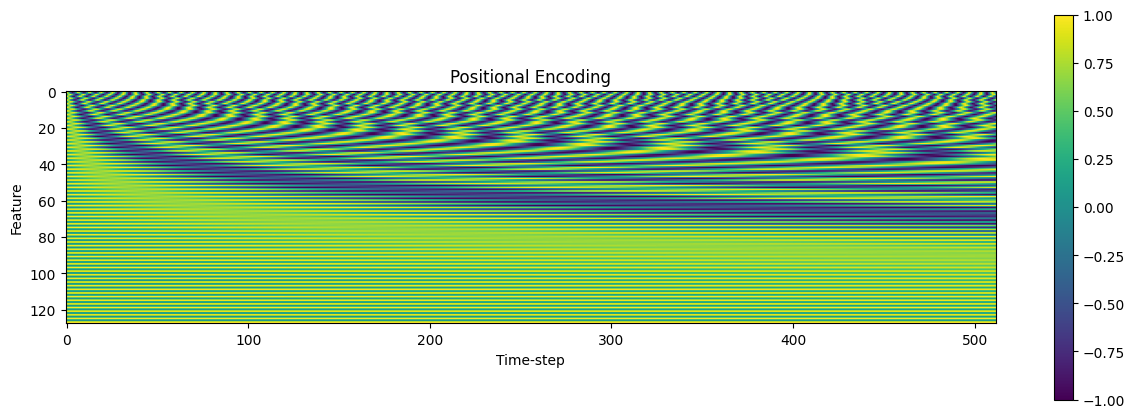

In [8]:
pe = PositionalEncoding(0)
x = torch.zeros(1, 512, 128)
y = pe(x)
plt.figure(figsize=(15, 5))
plt.title("Positional Encoding")
plt.imshow(y[0].T.detach().cpu().numpy())
plt.colorbar()
plt.xlabel("Time-step")
plt.ylabel("Feature")
plt.show()

## Tokenization

We used the GPT-2 tokenizer to tokenize the text descriptions.
We chose this tokenizer because it has a relatively small vocabulary size (50257 tokens) and, being a Byte-Pair Encoding (BPE) tokenizer, it can handle every word.

## Model

![model architecture](https://raw.githubusercontent.com/Etto48/CVProject/refs/heads/main/docs/graph_rendered.svg)

Our model takes as input the concatenation of the image embeddings (from DINOv2) and the text embeddings.
This model is an autoregressive model, like GPT.

The key difference is that we used a mask that is causal for text embeddings and non-causal for image embeddings because the image embeddings need to attend to each other while the text embeddings can only attend to the previous tokens and the image embeddings.

In [9]:
class Annotator(nn.Module):
    # for later
    from_pretrained: Callable
    encode_images: Callable
    forward_with_embeddings: Callable
    loss_fn: Callable
    fit: Callable
    save: Callable
    load: Callable
    _sample_search: Callable
    _greedy_search: Callable
    _beam_search: Callable
    annotate: Callable
    
    def __init__(self):
        super().__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.embedding_dim = 1024
        self.heads = 16
        self.decoder_block_depth = 6
        self.decoder_blocks = 3
        self.dropout = 0.1

        self.tokenizer = tiktoken.get_encoding("gpt2")
        self.embedding = nn.Sequential(
            nn.Embedding(
                num_embeddings=self.tokenizer.max_token_value + 1,
                embedding_dim=self.embedding_dim,
            ),
        )

        self.positional_encoding = PositionalEncoding(self.dropout)
       
        self.img_processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-large')
        self.img_embedding = transformers.AutoModel.from_pretrained('facebook/dinov2-large')

        for param in self.img_embedding.parameters():
            param.requires_grad = False

        self.causal = nn.ModuleList()
        for _ in range(self.decoder_blocks):
            self.causal.append(nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=self.embedding_dim,
                    nhead=self.heads,
                    dim_feedforward=self.embedding_dim * 4,
                    dropout=self.dropout,
                    batch_first=True,
                    activation="gelu"),
                num_layers=self.decoder_block_depth,
                enable_nested_tensor=True,
                norm=nn.LayerNorm(self.embedding_dim)
            ))

        self.deembedding = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.embedding_dim, self.tokenizer.max_token_value + 1)
        )
        self.to(self.device)

We will need this function to download the weights of the model from my Google Drive so that we don't have to train it on Colab.
Also the dataset is 20GB so it would take some time.

In [10]:
@staticmethod
def from_pretrained():
    url = "https://huggingface.co/Etto48/CVProject/resolve/main/data/annotator.pt"
    file_stream = requests.get(url, stream=True)
    file_stream.raise_for_status()
    file_size = int(file_stream.headers["Content-Length"])
    os.makedirs("data", exist_ok=True)
    if not os.path.exists("data/annotator.pt"):
        with open("data/annotator.pt", "wb") as f:
            with tqdm(total=file_size, desc="Downloading model weights", unit="B", unit_scale=True) as pbar:
                for chunk in file_stream.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
    else:
        if os.path.getsize("data/annotator.pt") != file_size:
            print("File size mismatch, maybe the file is an old version or a partial download. Please remove the file and try again.")
            return None
    annotator = Annotator.load("data/annotator.pt")
    return annotator
Annotator.from_pretrained = from_pretrained

This function encodes the images into image embeddings using DINOv2.

In [11]:
def encode_images(self: Annotator, images):
    img_inputs = self.img_processor(images, return_tensors="pt").to(self.device)
    image_embeddings = self.img_embedding(**img_inputs).last_hidden_state
    return image_embeddings
Annotator.encode_images = encode_images

This function takes as input the image embeddings computed by DINOv2 and the tokenized captions (generated up to the current token).
Every caption is prepended with a special token so that it's never empty.

This function then computes the embedding of the caption, adding positional encoding, concatenates it with the image embeddings, and passes it through the model together with the mask described above.

Then the image embeddings are discarded and the text embeddings are used to predict the next token probability distribution for each token in the caption using a linear layer.

In [12]:
def forward_with_embeddings(self: Annotator, generated_caption, image_embeddings):
    caption_embeddings: torch.Tensor = self.embedding(generated_caption)

    tgt_mask = nn.Transformer.generate_square_subsequent_mask(
        image_embeddings.shape[1] + caption_embeddings.shape[1], device=self.device)
    tgt_mask[:image_embeddings.shape[1], :image_embeddings.shape[1]] = 0
    caption_embeddings = self.positional_encoding(caption_embeddings)
    input_sequence = torch.cat([image_embeddings, caption_embeddings], dim=1)
    output_sequence = input_sequence

    for causal in self.causal:
        output_sequence = causal(output_sequence, mask=tgt_mask) + output_sequence
        output_sequence = nn.functional.layer_norm(output_sequence, output_sequence.shape[1:])
    
    output_sequence = output_sequence[:, image_embeddings.shape[1]:, :]
    output_sequence = self.deembedding(output_sequence)
    return output_sequence
Annotator.forward_with_embeddings = forward_with_embeddings

This function encodes the images and passes them to the previous function

In [13]:

def forward(self: Annotator, generated_caption, images):
        image_embeddings = self.encode_images(images)
        output_sequence = self.forward_with_embeddings(generated_caption, image_embeddings)
        return output_sequence
Annotator.forward = forward

The best loss for learning a probability distribution is the cross-entropy loss, which is the negative log-likelihood of the true token.

This loss is applied to each token and averaged over all the tokens. Also, we mask out the padding tokens so that they don't contribute to the loss.

In [14]:
@staticmethod
def loss_fn(generated_tokens: torch.Tensor, expected_output: torch.Tensor, lengths: torch.Tensor):
    mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
        .unsqueeze(0) < lengths.unsqueeze(1)
    loss = nn.functional.cross_entropy(generated_tokens[mask], expected_output[mask], reduction="mean")
    return loss
Annotator.loss_fn = loss_fn

We used the AdamW optimizer for its good performance in training transformers.

To avoid gradient explosion, we used gradient clipping to clip the gradients to a maximum norm of 1.

To avoid overfitting we used early stopping, which stops the training if the validation loss does not improve for a certain number of epochs.

We also used learning rate scheduling, which reduces the learning rate by a certain factor if the validation loss does not improve for a certain number of epochs.

In [15]:
def fit(self, train: TextImageDataset, valid: TextImageDataset, epochs: int):
    optim = torch.optim.Adam(self.parameters(), lr=5e-5)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, threshold=0.01)
    history = {"train": [], "valid": [], "lr": []}
    bs = 8
    train_loader = torch.utils.data.DataLoader(
        dataset=train, batch_size=bs, collate_fn=TextImageDataset.collate_fn,
        sampler=torch.utils.data.RandomSampler(train, replacement=True, num_samples=bs * 100))
    valid_loader = torch.utils.data.DataLoader(
        dataset=valid, batch_size=bs, collate_fn=TextImageDataset.collate_fn,
        sampler=torch.utils.data.RandomSampler(valid, replacement=True, num_samples=bs * 50))

    best_loss = float("inf")
    best_model = None
    patience = 10
    epochs_without_improvement = 0
    threshold = 0.01

    for epoch in range(epochs):
        batches = tqdm(
            train_loader,
            desc=f"Epoch {epoch + 1}/{epochs} (train)")
        self.train()
        avg_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for i, (images, captions, lengths, _) in enumerate(batches):
            images = images#.to(self.device)
            captions = captions.to(self.device)
            lengths = lengths.to(self.device)
            output_sequence = captions[:, :-1]
            expected_output = captions[:, 1:]
            optim.zero_grad()
            generated_tokens = self(output_sequence, images)
            loss: torch.Tensor = self.loss_fn(generated_tokens, expected_output, lengths)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), 1)
            optim.step()
            avg_loss += loss.item()
            mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
                .unsqueeze(0) < lengths.unsqueeze(1)
            next_tokens = generated_tokens.argmax(dim=-1)
            correct_predictions += (next_tokens[mask] == expected_output[mask]).sum().item()
            total_predictions += next_tokens.numel()
            batches.set_postfix(
                loss=avg_loss / (i + 1), accuracy=f"{correct_predictions / total_predictions:0.2%}", lr=optim.param_groups[0]["lr"])
        avg_loss /= i + 1
        history["train"].append(avg_loss)
        batches = tqdm(
            valid_loader,
            desc=f"Epoch {epoch + 1}/{epochs} (valid)")
        self.eval()
        avg_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for i, (images, captions, lengths, _) in enumerate(batches):
                images = images#.to(self.device)
                captions = captions.to(self.device)
                lengths = lengths.to(self.device)
                output_sequence = captions[:, :-1]
                expected_output = captions[:, 1:]
                generated_tokens = self(output_sequence, images)
                loss: torch.Tensor = self.loss_fn(generated_tokens, expected_output, lengths)
                avg_loss += loss.item()
                mask = torch.arange(generated_tokens.shape[1], device=generated_tokens.device)\
                    .unsqueeze(0) < lengths.unsqueeze(1)
                next_tokens = generated_tokens.argmax(dim=-1)
                correct_predictions += (next_tokens[mask] == expected_output[mask]).sum().item()
                total_predictions += next_tokens.numel()
                batches.set_postfix(
                    loss=avg_loss / (i + 1), accuracy=f"{correct_predictions / total_predictions:0.2%}", lr=optim.param_groups[0]["lr"])
        avg_loss /= i + 1
        history["valid"].append(avg_loss)
        lr_scheduler.step(loss)
        history["lr"].append(optim.param_groups[0]["lr"])
        if avg_loss < best_loss - threshold:
            best_loss = avg_loss
            best_model = self.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break
    self.load_state_dict(best_model)
    return history
Annotator.fit = fit

Here is a plot of the training history of the model. The training took approximately 1h on an NVIDIA 4070 SUPER.

![training history](https://raw.githubusercontent.com/Etto48/CVProject/main/docs/history.png)

These functions are needed to save and load the model weights.

In [16]:
def save(self: Annotator, path: str):
    torch.save(self.state_dict(), path)
Annotator.save = save

@staticmethod
def load(path: str):
    annotator = Annotator()
    annotator.load_state_dict(torch.load(
        path, map_location=annotator.device, weights_only=True))
    return annotator
Annotator.load = load

This is the simplest algorithm to generate a caption for an image. At each step, we select the most probable token and append it to the caption.

In [17]:
def _greedy_search(self, image_embeddings: torch.Tensor, max_length: int, conditioning: Optional[str]):
    batch_size = image_embeddings.shape[0]
    if conditioning is not None:
        conditioning = self.tokenizer.encode(conditioning)
        captions = torch.full((batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        captions[:, 1:] = torch.tensor(conditioning, device=self.device).view(1, -1)
    else:
        captions = torch.full((batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
    finished = torch.full((batch_size,), False, dtype=torch.bool, device=self.device)
    if conditioning is not None:
        lengths = torch.full((batch_size,), len(conditioning), dtype=torch.long, device=self.device)
    else:
        lengths = torch.full((batch_size,), 1, dtype=torch.long, device=self.device)
    probabilities = torch.full((batch_size,), 1.0, dtype=torch.float32, device=self.device)
    loading_bar = tqdm(total=max_length, desc="Generating captions (greedy)")
    while True:
        generated_tokens_distribution = self.forward_with_embeddings(captions, image_embeddings)[:, -1]
        generated_tokens = generated_tokens_distribution.argmax(dim=-1)
        probabilities *= torch.softmax(generated_tokens_distribution, dim=-1)[torch.arange(batch_size), generated_tokens]
        finished |= (generated_tokens == self.tokenizer.max_token_value)
        if finished.all():
            break
        lengths += ~finished
        captions = torch.cat([captions, generated_tokens.unsqueeze(1)], dim=1)
        if max_length is not None and captions.shape[1] >= max_length:
            break
        loading_bar.update(1)
    loading_bar.close()
    return captions, lengths, probabilities, finished
Annotator._greedy_search = _greedy_search

This is a bit more complex but still simple. At each step, we sample a token from the multinomial distribution of the predicted probabilities.
Optionally, we can choose to sample from only the top-k most probable tokens.

In [18]:
def _sample_search(self: Annotator, image_embeddings: torch.Tensor, max_length: int, top_k: Optional[int], conditioning: Optional[str]):
    batch_size = image_embeddings.shape[0]
    if conditioning is not None:
        conditioning = self.tokenizer.encode(conditioning)
        captions = torch.full((batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        captions[:, 1:] = torch.tensor(conditioning, device=self.device).view(1, -1)
    else:
        captions = torch.full((batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
    finished = torch.full((batch_size,), False, dtype=torch.bool, device=self.device)
    if conditioning is not None:
        lengths = torch.full((batch_size,), len(conditioning), dtype=torch.long, device=self.device)
    else:
        lengths = torch.full((batch_size,), 1, dtype=torch.long, device=self.device)
    probabilities = torch.full((batch_size,), 1.0, dtype=torch.float32, device=self.device)
    loading_bar = tqdm(total=max_length, desc="Generating captions (sample)")
    while True:
        generated_tokens_distribution = self.forward_with_embeddings(captions, image_embeddings)[:, -1]
        match top_k:
            case None:
                generated_tokens = torch.multinomial(
                    torch.softmax(generated_tokens_distribution, dim=-1), 1)\
                    .squeeze(1)
            case _:
                top_k_values, top_k_indices = torch.topk(
                    generated_tokens_distribution, top_k, dim=-1)
                top_k_probabilities = torch.softmax(top_k_values, dim=-1)
                generated_tokens = torch.multinomial(
                    top_k_probabilities, 1)\
                    .squeeze(1)
                generated_tokens = top_k_indices[torch.arange(batch_size), generated_tokens]
        probabilities *= torch.softmax(generated_tokens_distribution, dim=-1)[torch.arange(batch_size), generated_tokens]
        finished |= (generated_tokens == self.tokenizer.max_token_value)
        if finished.all():
            break
        lengths += ~finished
        captions = torch.cat([captions, generated_tokens.unsqueeze(1)], dim=1)
        if max_length is not None and captions.shape[1] >= max_length:
            break
        loading_bar.update(1)
    loading_bar.close()
    return captions, lengths, probabilities, finished
Annotator._sample_search = _sample_search

This is the most complex of the three. We keep track of the top-k most probable captions at each step. When we generate the next token, we choose for each caption the top-k most probable sentences and discard the others.

In [19]:
def _beam_search(self: Annotator, image_embeddings: torch.Tensor, max_length: int, beam_size: int, conditioning: Optional[str]):
    batch_size = image_embeddings.shape[0]
    if conditioning is not None:
        conditioning = self.tokenizer.encode(conditioning)
        captions = torch.full((beam_size, batch_size, len(conditioning) + 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
        captions[:, :, 1:] = torch.tensor(conditioning, device=self.device).view(1, 1, -1)
    else:
        captions = torch.full((beam_size, batch_size, 1), self.tokenizer.max_token_value, dtype=torch.long, device=self.device)
    finished = torch.full((beam_size, batch_size), False, dtype=torch.bool, device=self.device)
    if conditioning is not None:
        lengths = torch.full((beam_size, batch_size), len(conditioning), dtype=torch.long, device=self.device)
    else:
        lengths = torch.full((beam_size, batch_size), 1, dtype=torch.long, device=self.device)
    probabilities = torch.full((beam_size, batch_size), 1.0, dtype=torch.float32, device=self.device)
    loading_bar = tqdm(total=max_length, desc="Generating captions (beam)")
    while True:
        generated_tokens_distribution = \
            self.forward_with_embeddings(captions.view(-1, captions.shape[-1]), image_embeddings.repeat(beam_size, 1, 1))[:, -1] \
                .view(beam_size, batch_size, -1)

        # Select top k tokens for each beam
        top_k_values_for_beam, top_k_indices_for_beam = torch.topk(
            generated_tokens_distribution, beam_size, dim=-1)
        
        # Compute probabilities for each beam [beam, batch, beam]
        top_k_probabilities_for_beam = torch.softmax(top_k_values_for_beam, dim=-1)
        top_k_probabilities_for_beam *= probabilities.unsqueeze(-1) 

        # Select top k beams 
        # [beam*beam, batch]
        top_k_squared_probabilities = top_k_probabilities_for_beam.permute(0, 2, 1).reshape(beam_size * beam_size, batch_size)
        # [beam, batch]
        top_k_probabilities, top_k_indices = torch.topk(
            top_k_squared_probabilities, beam_size, dim=0)
        
        new_tokens = top_k_indices_for_beam.permute(0, 2, 1).reshape(beam_size * beam_size, batch_size)[top_k_indices, torch.arange(batch_size)]
        probabilities = top_k_probabilities
        new_finished = (new_tokens == self.tokenizer.max_token_value)
        finished |= new_finished

        if finished.all():
            break
        lengths += ~finished
        captions = torch.cat([captions.view(-1, batch_size, captions.shape[-1]), new_tokens.view(beam_size, batch_size, 1)], dim=2)
        if max_length is not None and captions.shape[2] >= max_length:
            break
        loading_bar.update(1)
    loading_bar.close()
    
    best_beam_for_batch_idx = torch.argmax(probabilities, dim=0)
    best_beam = captions[best_beam_for_batch_idx, torch.arange(batch_size), :]
    return best_beam, lengths[best_beam_for_batch_idx, torch.arange(batch_size)], probabilities[best_beam_for_batch_idx, torch.arange(batch_size)], finished[best_beam_for_batch_idx, torch.arange(batch_size)]
Annotator._beam_search = _beam_search

Finally, this is the function that calls one of the three generation algorithms and returns the generated caption for each input image.

In [20]:
def annotate(self: Annotator, images, max_length: int = 15, mode: Literal["greedy", "sample", "beam"] = "greedy", top_k: Optional[int] = None, conditioning: Optional[str] = None):
    self.eval()
    batched = isinstance(images, list) or isinstance(images, tuple)
    with torch.no_grad():
        images = images
        images = [images] if not batched else images
        image_embeddings = self.encode_images(images)

        match mode:
            case "greedy":
                captions, lengths, probabilities, finished = self._greedy_search(image_embeddings, max_length, conditioning)
            case "sample":
                captions, lengths, probabilities, finished = self._sample_search(image_embeddings, max_length, top_k, conditioning)
            case "beam":
                captions, lengths, probabilities, finished = self._beam_search(image_embeddings, max_length, top_k, conditioning)
            
    outputs = []
    for i in range(captions.shape[0]):
        caption = captions[i, 1:lengths[i]].cpu().numpy()
        output = self.tokenizer.decode(caption)
        if not finished[i]:
            output += "..."
        outputs.append(output)
    if batched:
        return outputs, probabilities
    else:
        assert len(outputs) == 1
        return outputs[0], probabilities[0]
Annotator.annotate = annotate

Now let's see the model in action.

Loading annotator...


Generating captions (greedy):  80%|████████  | 12/15 [02:30<00:37, 12.50s/it]


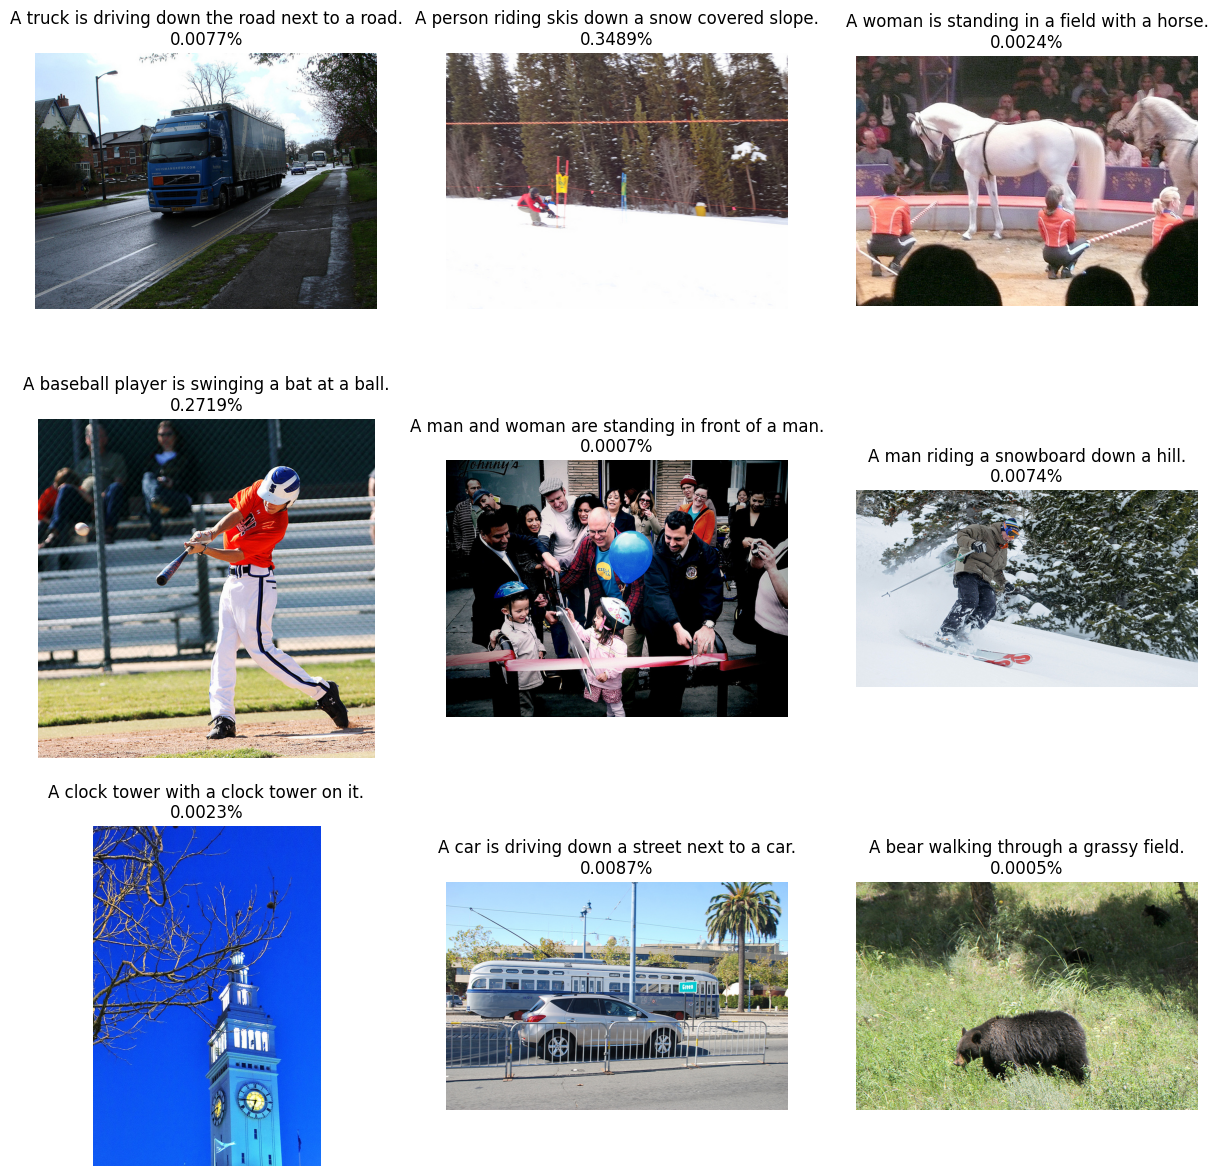

In [21]:
try:
    print("Loading annotator...")
    annotator = Annotator.from_pretrained()
except FileNotFoundError:
    print("Annotator pretrained weights not found at \"data/annotator.pt\"")
    exit(1)
l = 3
valid_loader = torch.utils.data.DataLoader(
    dataset=valid, batch_size=l * l, collate_fn=TextImageDataset.collate_fn,
    sampler=torch.utils.data.RandomSampler(valid, replacement=True, num_samples=l * l))
images, _, _, _ = next(iter(valid_loader))
captions, probabilities = annotator.annotate(images, mode="beam", top_k=10)
plt.figure(figsize=(15, 15))
for i in range(l * l):
    plt.subplot(l, l, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(captions[i] + "\n" + f"{probabilities[i]:.4%}")
    plt.axis("off")
plt.show()